<a href="https://colab.research.google.com/github/ozlemakboyraz/Brain-Classification-Project/blob/main/InceptionV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_auc_score, roc_curve,auc
from sklearn.model_selection import StratifiedKFold

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision import datasets, models, transforms

# 1. GPU (CUDA) Otomatik Algılama
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Kullanılan Cihaz: {device}")

Kullanılan Cihaz: cuda


In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
!cp "/content/drive/MyDrive/brain-dataset/Dataset_224x224.rar" /content/
!unrar x /content/Dataset_224x224.rar /content/

Görüntülenen çıkış son 5000 satıra kısaltıldı.
Extracting  /content/Dataset_224x224/Training/glioma/Tr-gl_0713.jpg       26%  OK 
Extracting  /content/Dataset_224x224/Training/glioma/Tr-gl_0714.jpg       26%  OK 
Extracting  /content/Dataset_224x224/Training/glioma/Tr-gl_0715.jpg       26%  OK 
Extracting  /content/Dataset_224x224/Training/glioma/Tr-gl_0716.jpg       26%  OK 
Extracting  /content/Dataset_224x224/Training/glioma/Tr-gl_0717.jpg       26%  OK 
Extracting  /content/Dataset_224x224/Training/glioma/Tr-gl_0718.jpg       26%  OK 
Extracting  /content/Dataset_224x224/Training/glioma/Tr-gl_0719.jpg       26%  OK 
Extracting  /content/Dataset_224x224/Training/glioma/Tr-gl_0720.jpg       26%  OK 
Extracting  /content/Dataset_224x224/Training/glioma/Tr-gl_0721.jpg       26%  OK 
Extracting  /content/Dataset_224x224/Training/glioma/Tr-gl_0722.jpg       26%  OK 
Extracting  /content/Dataset_224x

In [22]:
# 2. Veri Yolları ve Parametreler
# InceptionV3 için standart giriş boyutu 299x299'dur.
DATA_DIR = '/content//Dataset_224x224'
TRAIN_DIR = os.path.join(DATA_DIR, 'Training')
TEST_DIR = os.path.join(DATA_DIR, 'Testing')

IMG_SIZE = 299
BATCH_SIZE = 32
NUM_CLASSES = 4
EPOCHS_PER_FOLD = 10



In [23]:
# 3. MRI Görüntüleri İçin Özel Data Augmentation
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    transforms.ColorJitter(brightness=0.15, contrast=0.15),
    transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

val_test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [24]:
# 4. InceptionV3 Model Yapılandırması ve Kademeli Fine-Tuning
def get_inception_model():
    # Pretrained InceptionV3 yükleme
    model = models.inception_v3(weights=models.Inception_V3_Weights.IMAGENET1K_V1)
    model.aux_logits = False # Yardımcı çıkışı kapatıyoruz (sadece ana çıkışla 4 sınıf)

    # InceptionV3 derin bir modeldir. Yaklaşık %40 dondurma için:
    # BasicConv2d ve ilk Inception bloklarını (Mixed_5b'ye kadar) donduruyoruz.
    child_list = list(model.children())
    freeze_limit = int(len(child_list) * 0.4)

    for i, child in enumerate(model.children()):
        if i < freeze_limit:
            for param in child.parameters():
                param.requires_grad = False
        else:
            for param in child.parameters():
                param.requires_grad = True

    # Çıkış katmanını (Fully Connected) 4 sınıf için güncelleme
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, NUM_CLASSES)

    return model.to(device)

In [25]:
# 5. Dataset Sınıfı
class BrainMRIDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.dataset = datasets.ImageFolder(root_dir)
        self.transform = transform
        self.classes = self.dataset.classes
    def __getitem__(self, index):
        image, label = self.dataset[index]
        if self.transform: image = self.transform(image)
        return image, label
    def __len__(self):
        return len(self.dataset)


In [26]:
# 6. 5-Fold Stratified Cross-Validation (Ortalama Hesaplamalı)
full_train_dataset = BrainMRIDataset(TRAIN_DIR)
labels = [sample[1] for sample in full_train_dataset.dataset.samples]
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

all_fold_histories = []

for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(labels)), labels)):
    print(f"\n--- FOLD {fold+1} BAŞLIYOR ---")
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    train_sub = Subset(full_train_dataset, train_idx)
    val_sub = Subset(full_train_dataset, val_idx)

    # Transformları atama
    train_sub.dataset.transform = train_transforms
    val_sub.dataset.transform = val_test_transforms

    train_loader = DataLoader(train_sub, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_sub, batch_size=BATCH_SIZE, shuffle=False)

    model = get_inception_model()

    # Differential Learning Rate Tanımlama
    # Inception blok isimlerine göre katman gruplandırma:
    optimizer = optim.Adam([
        {'params': model.Mixed_5b.parameters(), 'lr': 1e-5}, # layer2 dengi
        {'params': model.Mixed_6a.parameters(), 'lr': 5e-5}, # layer3 dengi
        {'params': model.Mixed_7a.parameters(), 'lr': 1e-4}, # layer4 dengi
        {'params': model.fc.parameters(), 'lr': 1e-3}       # fully connected
    ])

    criterion = nn.CrossEntropyLoss()

    for epoch in range(EPOCHS_PER_FOLD):
        # Training
        model.train()
        t_loss, t_corr = 0.0, 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            _, preds = torch.max(outputs, 1)
            t_loss += loss.item() * inputs.size(0)
            t_corr += torch.sum(preds == targets.data)

        # Validation
        model.eval()
        v_loss, v_corr = 0.0, 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                _, preds = torch.max(outputs, 1)
                v_loss += loss.item() * inputs.size(0)
                v_corr += torch.sum(preds == targets.data)

        history['train_loss'].append(t_loss/len(train_idx))
        history['train_acc'].append((t_corr.double()/len(train_idx)).cpu().item())
        history['val_loss'].append(v_loss/len(val_idx))
        history['val_acc'].append((v_corr.double()/len(val_idx)).cpu().item())
        print(f"Epoch {epoch+1}: Train Acc: {history['train_acc'][-1]:.4f} | Val Acc: {history['val_acc'][-1]:.4f}")

    all_fold_histories.append(history)



--- FOLD 1 BAŞLIYOR ---
Epoch 1: Train Acc: 0.7590 | Val Acc: 0.9081
Epoch 2: Train Acc: 0.9234 | Val Acc: 0.9501
Epoch 3: Train Acc: 0.9608 | Val Acc: 0.9650
Epoch 4: Train Acc: 0.9836 | Val Acc: 0.9668
Epoch 5: Train Acc: 0.9834 | Val Acc: 0.9615
Epoch 6: Train Acc: 0.9891 | Val Acc: 0.9729
Epoch 7: Train Acc: 0.9976 | Val Acc: 0.9781
Epoch 8: Train Acc: 0.9952 | Val Acc: 0.9746
Epoch 9: Train Acc: 0.9952 | Val Acc: 0.9685
Epoch 10: Train Acc: 0.9952 | Val Acc: 0.9703

--- FOLD 2 BAŞLIYOR ---
Epoch 1: Train Acc: 0.7722 | Val Acc: 0.9239
Epoch 2: Train Acc: 0.9289 | Val Acc: 0.9501
Epoch 3: Train Acc: 0.9654 | Val Acc: 0.9624
Epoch 4: Train Acc: 0.9777 | Val Acc: 0.9606
Epoch 5: Train Acc: 0.9902 | Val Acc: 0.9703
Epoch 6: Train Acc: 0.9928 | Val Acc: 0.9711
Epoch 7: Train Acc: 0.9950 | Val Acc: 0.9738
Epoch 8: Train Acc: 0.9952 | Val Acc: 0.9746
Epoch 9: Train Acc: 0.9980 | Val Acc: 0.9746
Epoch 10: Train Acc: 0.9967 | Val Acc: 0.9729

--- FOLD 3 BAŞLIYOR ---
Epoch 1: Train Acc: 0.7

In [27]:
# 7. Test Seti Üzerinde Final Değerlendirme
print("\n--- TEST SETİ DEĞERLENDİRMESİ ---")
test_dataset = BrainMRIDataset(TEST_DIR, transform=val_test_transforms)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

all_preds, all_labels, all_probs = [], [], []
model.eval()
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        all_probs.extend(torch.softmax(outputs, dim=1).cpu().numpy())
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(targets.cpu().numpy())

# Sayısal Test Sonuçları
acc = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
roc_auc = roc_auc_score(all_labels, all_probs, multi_class='ovr')

print(f"\nSayısal Test Sonuçları:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")


--- TEST SETİ DEĞERLENDİRMESİ ---

Sayısal Test Sonuçları:
Accuracy:  0.9649
Precision: 0.9663
Recall:    0.9649
F1-Score:  0.9650
ROC-AUC:   0.9967


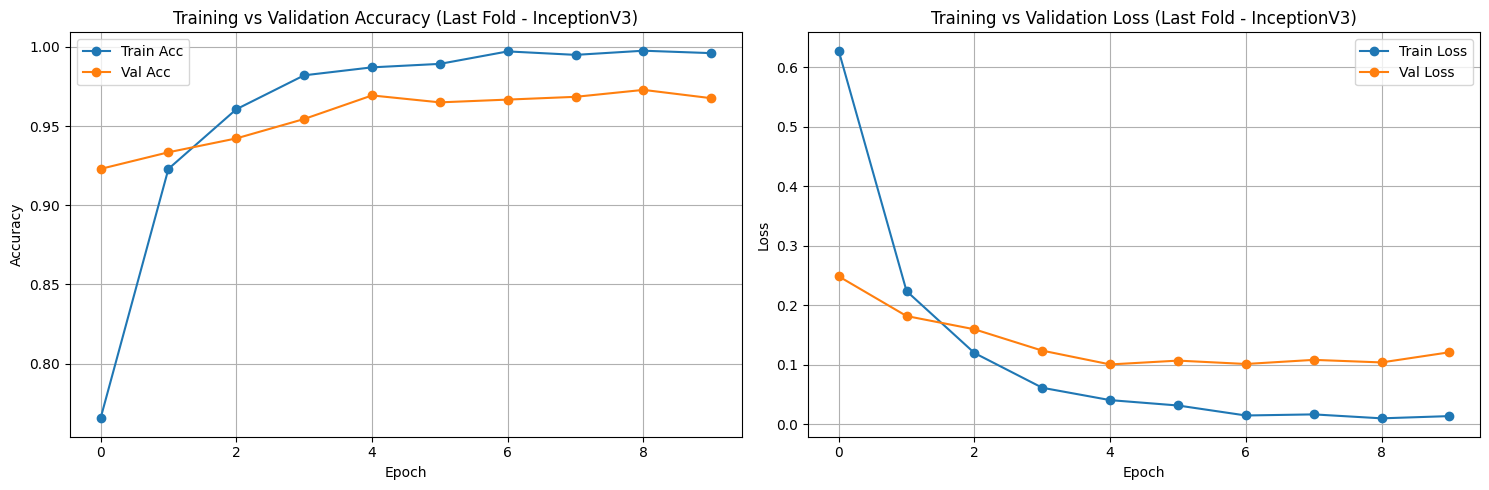

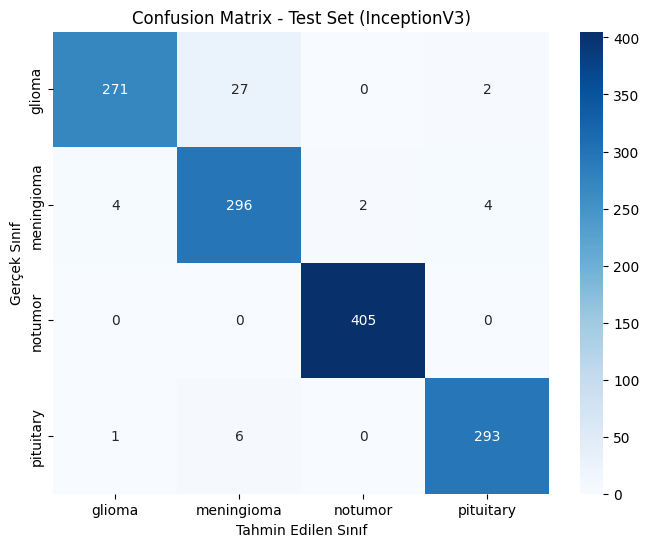

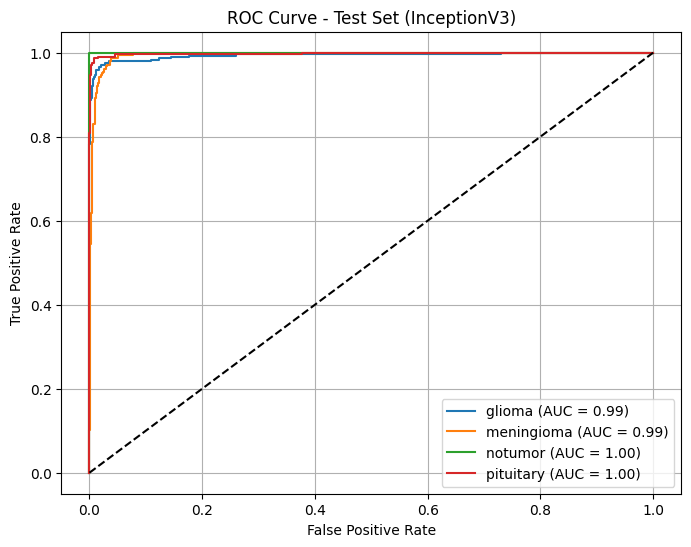

In [28]:
# 8. GRAFİKLER

# --- A. Training vs Validation Accuracy & Loss (Son Fold)
plt.figure(figsize=(15, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(all_fold_histories[-1]['train_acc'], label='Train Acc', marker='o')
plt.plot(all_fold_histories[-1]['val_acc'], label='Val Acc', marker='o')
plt.title('Training vs Validation Accuracy (Last Fold - InceptionV3)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(all_fold_histories[-1]['train_loss'], label='Train Loss', marker='o')
plt.plot(all_fold_histories[-1]['val_loss'], label='Val Loss', marker='o')
plt.title('Training vs Validation Loss (Last Fold - InceptionV3)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# --- B. Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.title('Confusion Matrix - Test Set (InceptionV3)')
plt.ylabel('Gerçek Sınıf')
plt.xlabel('Tahmin Edilen Sınıf')
plt.show()


# --- C. ROC Eğrisi
plt.figure(figsize=(8, 6))
all_labels_np = np.array(all_labels)
all_probs_np = np.array(all_probs)

for i in range(NUM_CLASSES):
    fpr, tpr, _ = roc_curve(all_labels_np == i, all_probs_np[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{test_dataset.classes[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve - Test Set (InceptionV3)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()